In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.nn import MSELoss
import torch.nn.functional as F
import torchmetrics
from torchmetrics import MeanSquaredError,PearsonCorrCoef
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --no-index --find-links=file:///torch-geometric
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data,Dataset
from torch_geometric.nn import GCNConv, GATConv,global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch.optim.lr_scheduler import StepLR,ExponentialLR
from torchmetrics import R2Score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
dataset=[]
for i in range(0,400):
    dataset.append(torch.load("graphs/graph"+str(i)+".pt"))
    dataset[i].x=dataset[i].x.type(torch.float32)
    dataset[i].edge_attr=dataset[i].edge_attr.type(torch.float32)

In [13]:
dataset[0]

Data(x=[4096, 1], edge_index=[2, 167710], edge_attr=[167710, 3], y=[4096, 1], pos=[4096, 3], e_pot=0, pair_pot=0, edge_targets=[167710, 1], delta_r_cage=[4096, 1])

In [14]:
train_loader=DataLoader(dataset[:350],batch_size=10,shuffle=True)
test_loader=DataLoader(dataset[350:],batch_size=10,shuffle=False)

In [15]:
device

device(type='cuda')

In [16]:
pearson_correr=PearsonCorrCoef().to(device)
r2_scorer=R2Score().to(device)

In [17]:
def evaluate():
    model.eval()
    outs=torch.empty(0).to(device)
    ys=torch.empty(0).to(device)
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        outs=torch.cat((outs,out.flatten()))
        ys=torch.cat((ys,data.y.flatten()))
        #data.cpu()
    pearson=pearson_correr(outs,ys)
    r2=r2_scorer(outs,ys)
    return pearson.item(),r2.item()

In [18]:
class GATCONVModel(torch.nn.Module):
    def __init__(self,hidden_dim=6,attention_heads=6,dropout_rate=0.0):
        super(GATCONVModel,self).__init__()
        torch.manual_seed(46)
        self.encoder= nn.Sequential(
            nn.Linear(3,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU()
        )
        self.conv1=GATConv(1,hidden_dim,heads=attention_heads,dropout=dropout_rate,edge_dim=16)
        self.conv2=GATConv(hidden_dim*attention_heads,hidden_dim,heads=attention_heads,dropout=dropout_rate,edge_dim=16)
        #self.conv3=GATConv(hidden_dim*attention_heads,hidden_dim,heads=attention_heads,dropout=dropout_rate,edge_dim=3)
        self.lin=nn.Linear(hidden_dim*attention_heads,1)
        
    def forward(self,data):
        x,edge_index,edge_attr=data.x,data.edge_index,data.edge_attr
        edge_attr=self.encoder(edge_attr)
        x=self.conv1(x,edge_index,edge_attr)
        #print(x.shape,x)
        x=self.conv2(x,edge_index,edge_attr)
        #print(x.shape,x)
        #x=self.conv3(x,edge_index,edge_attr)
        x=self.lin(x)
        #print(x.shape,x)
        return x

In [19]:
loss_fn=MSELoss()
model=GATCONVModel().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-6)
#scheduler = StepLR(optimizer,step_size=20, gamma=0.5)
train_losses=[]
test_losses=[]
for epoch in range(150):
    if epoch%1==0 and epoch!=0:
        print("epoch:",epoch,"| loss:",train_losses[-1]," | pearson_corr:",evaluate()[0]," | r2_score:",evaluate()[1])
    batch_losses=[]
    model.train()
    for data in train_loader:
        data=data.to(device)
        optimizer.zero_grad()
        out=model(data)
        loss=loss_fn(out,data.y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        #data.cpu()
    train_losses.append(np.mean(batch_losses))
    
    model.eval()
    batch_losses=[]
    for data in test_loader:
        data=data.to(device)
        out=model(data)
        loss=loss_fn(out,data.y)
        batch_losses.append(loss.item())
        #data.cpu()
    test_losses.append(np.mean(batch_losses))
    #scheduler.step()

epoch: 1 | loss: 0.11342755470957075  | pearson_corr: -0.1128758117556572  | r2_score: -0.02818167209625244
epoch: 2 | loss: 0.09574131923062461  | pearson_corr: 0.30126363039016724  | r2_score: 0.05176818370819092
epoch: 3 | loss: 0.08367049672773906  | pearson_corr: 0.37438833713531494  | r2_score: 0.13716107606887817
epoch: 4 | loss: 0.0809024853365762  | pearson_corr: 0.40349525213241577  | r2_score: 0.16164332628250122
epoch: 5 | loss: 0.07748470221246992  | pearson_corr: 0.4596940577030182  | r2_score: 0.19073206186294556
epoch: 6 | loss: 0.07444366642407009  | pearson_corr: 0.48259562253952026  | r2_score: 0.23192989826202393
epoch: 7 | loss: 0.07283639716250556  | pearson_corr: 0.4982045888900757  | r2_score: 0.24607008695602417
epoch: 8 | loss: 0.0713831997343472  | pearson_corr: 0.5098007321357727  | r2_score: 0.2584807872772217
epoch: 9 | loss: 0.07058365919760295  | pearson_corr: 0.5179438591003418  | r2_score: 0.2672581076622009
epoch: 10 | loss: 0.06978941825883729  | pea

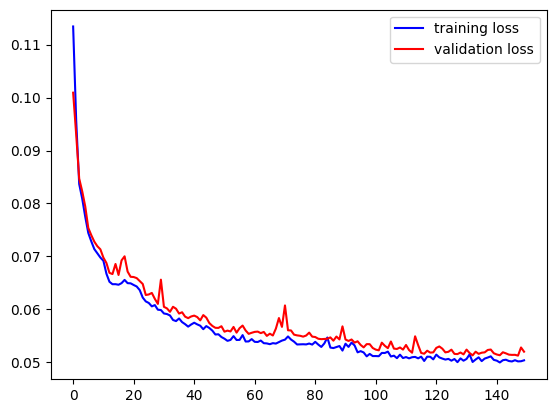

In [26]:
plt.plot(train_losses,color='blue')
plt.plot(test_losses,color='red')
plt.legend(["training loss","validation loss"])
plt.show()

In [25]:
final_results=evaluate()
print("Pearson_Corr=",final_results[0],"| R2_Score=",final_results[1])

Pearson_Corr= 0.6908356547355652 | R2_Score= 0.47014546394348145
